# Retail Sales Forecasting using the M5 dataset with Granite Time Series - Few-shot finetuning, evaluation, and visualization

In this tutorial, we will explore [timeseries forecasting](https://www.ibm.com/think/insights/time-series-forecasting) using the [IBM Granite Timeseries model](https://ibm.com/granite) to predict retail sales. We will cover key techniques such as few-shot forecasting and fine-tuning. We are using  [M5 datasets](https://drive.google.com/drive/folders/1D6EWdVSaOtrP1LEFh1REjI3vej6iUS_4?usp=sharing) from the official M-Competitions [repository](https://github.com/Mcompetitions/M5-methods) to forecast future sales aggregated by state. The aim of this recipe is to showcase how to use a pre-trained time series foundation model for multivariate forecasting and explores various features available with Granite Time Series Foundation Models.

This recipe uses TinyTimeMixers (TTMs), which are compact pre-trained models for Multivariate Time-Series Forecasting, open-sourced by IBM Research. With less than 1 Million parameters, TTM introduces the notion of the first-ever "tiny" pre-trained models for Time-Series Forecasting. TTM outperforms several popular benchmarks demanding billions of parameters in zero-shot and few-shot forecasting and can easily be fine-tuned for multivariate forecasts.

## Setting Up

### Install the TSFM Library

The [granite-tsfm library](https://github.com/ibm-granite/granite-tsfm) provides utilities for working with Time Series Foundation Models (TSFM). Here we retrieve and install the latest version of the library.

In [1]:
# Install the tsfm library
! pip install "granite-tsfm[notebooks]==0.2.23"
# Install a utility to help download data files from google drive during the data prep process
! pip install gdown

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 55.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 43.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 50.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3

### Import Packages

From `tsfm_public`, we use the TinyTimeMixer model, forecasting pipeline, and plotting function. We also leverage a few components for the fine-tuning process.

In [2]:
import math
import os

import numpy as np
import pandas as pd
import torch
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from torch.utils.data import Subset
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments, set_seed

from tsfm_public import (
    ForecastDFDataset,
    TimeSeriesForecastingPipeline,
    TimeSeriesPreprocessor,
    TinyTimeMixerForPrediction,
    TrackingCallback,
    count_parameters,
)
from tsfm_public.toolkit.lr_finder import optimal_lr_finder
from tsfm_public.toolkit.time_series_preprocessor import prepare_data_splits
from tsfm_public.toolkit.util import select_by_timestamp
from tsfm_public.toolkit.visualization import plot_predictions

### Specify configuration variables

The forecast length is specified as well as the context length (in time steps) which is set to match the pretrained model. Additionally, we declare the Granite Time Series Model and the specific revision we are targeting.

The granite-timeseries TTM R2 card has several different revisions of the model available for various context lengths and prediction lengths. In this example we will be working with daily data, so we choose a model suitable for that resolution -- 90 days of history to forecast the next 30 days.

In [3]:
forecast_length = 28
context_length = 90

TTM_MODEL_PATH = "ibm-granite/granite-timeseries-ttm-r2"
REVISION = "90-30-ft-l1-r2.1"

device = "cuda" if torch.cuda.is_available() else "cpu"

## Preparing the Data

As mentioned in the introduction, this notebook makes use of the [M5 datasets](https://drive.google.com/drive/folders/1D6EWdVSaOtrP1LEFh1REjI3vej6iUS_4?usp=sharing) from the official M-Competitions [repository](https://github.com/Mcompetitions/M5-methods).


The original data includes hierarchy and product information. For this example we aggregate the sales by state into three separate time series. The code for downloading the datasets and preparing them is available in `M5_retail_data_prep.py`. Here, we first make sure we have access to the `M5_retail_data_prep.py` file (in an environment like colab, we need to download the file) and then we simply run the `prepare_data()` function to save the prepared dataset.


In [4]:
import requests


def download_file(file_url, destination):
    if os.path.exists(destination):
        return
    response = requests.get(file_url)
    if response.status_code == 200:
        with open(destination, "wb") as file:
            file.write(response.content)
        # logger.info(f"Downloaded: {destination}")
    else:
        print(f"Failed to download {file_url}. Status code: {response.status_code}")


download_file(
    file_url="https://raw.githubusercontent.com/ibm-granite-community/granite-timeseries-cookbook/refs/heads/main/recipes/Retail_Forecasting/M5_retail_data_prep.py",
    destination="./M5_retail_data_prep.py",
)

In [5]:
# From the file we just made sure we had access to, import the data prep method
from M5_retail_data_prep import prepare_data

prepare_data()

Downloading...
From: https://drive.google.com/uc?id=1Bj7Xj15yn4j6-BM_mpSmOVTV0c2ihEdo
To: /content/temp/sales_test_evaluation.csv
100%|██████████| 3.26M/3.26M [00:00<00:00, 68.9MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1-khP8tp1gRTfaQQV_PlKd6R_3Mw5KiBw
From (redirected): https://drive.google.com/uc?id=1-khP8tp1gRTfaQQV_PlKd6R_3Mw5KiBw&confirm=t&uuid=35d8071b-2164-4ab7-9f07-fd4ff5a70f99
To: /content/temp/sales_train_evaluation.csv
100%|██████████| 121M/121M [00:03<00:00, 36.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1eeU8Me44yzgWsDD0dYrX4xVOixil_H4u
To: /content/temp/calendar.csv
100%|██████████| 112k/112k [00:00<00:00, 25.1MB/s]


Successfully saved the prepared M5 data to m5_for_state_level_forecasting.csv.gz.


### Read in the data

We parse the CSV into a pandas dataframe and ensure the timestamp column is a UTC datetime and drop two unnecessary columns.

In [6]:
data_path = "m5_for_state_level_forecasting.csv.gz"

data = pd.read_csv(data_path, parse_dates=["date"]).drop(columns=["d", "weekday"])
data.head()

,state_id,sales,date,wm_yr_wk,wday,month,year,snap_CA,snap_TX,snap_WI,event_name_1,event_type_1,event_name_2,event_type_2,wm_yr_wk_sin,wday_sin,month_sin,enc_state_id_mean,enc_state_id_std,state_id_cat
0,CA,14195,2011-01-29,0,0,0,2011,0,0,0,noevent,noevent,noevent,noevent,0.0,0.000000,0.0,14989.831155,3257.223505,CA
1,TX,9438,2011-01-29,0,0,0,2011,0,0,0,noevent,noevent,noevent,noevent,0.0,0.000000,0.0,9879.250392,1964.928938,TX
2,WI,8998,2011-01-29,0,0,0,2011,0,0,0,noevent,noevent,noevent,noevent,0.0,0.000000,0.0,9472.480920,2563.314535,WI
3,CA,13805,2011-01-30,0,1,0,2011,0,0,0,noevent,noevent,noevent,noevent,0.0,0.781831,0.0,14989.831155,3257.223505,CA
4,TX,9630,2011-01-30,0,1,0,2011,0,0,0,noevent,noevent,noevent,noevent,0.0,0.781831,0.0,9879.250392,1964.928938,TX


Next, we must clean up the columns in our data and declare the names of the timestamp column, the target column to be predicted as well as the categorical column used to aggregate the data.

In [7]:
cols = list(data.columns)
[cols.remove(c) for c in ["date", "sales", "state_id", "state_id_cat"]]
cols

column_specifiers = {
    "timestamp_column": "date",
    "id_columns": ["state_id"],
    "target_columns": ["sales"],
    "control_columns": cols,
    "static_categorical_columns": ["state_id_cat"],
    "categorical_columns": [
        "event_name_1",
        "event_type_1",
        "event_name_2",
        "event_type_2",
    ],
}

### Train the Preprocessor

The preprocessor is trained on the training portion of the input data to learn the scaling factors. The scaling will be applied when we use the preprocess method of the time series preprocessor.

In [8]:
tsp = TimeSeriesPreprocessor(
    **column_specifiers,
    context_length=context_length,
    prediction_length=forecast_length,
    scaling=True,
    encode_categorical=True,
    scaler_type="standard",
)

df_train = select_by_timestamp(
    data, timestamp_column=column_specifiers["timestamp_column"], end_timestamp="2016-05-23"
)

trained_tsp = tsp.train(df_train)

## Finetune the model

Now we will focus on fine-tuning the pretrained model. We use the same data splits we defined above, but now include extra columns during the fine-tuning process.

### Preparing the data for fine-tuning

We split the data into training, validation, and test sets. The training set is used to train the model, while the test set is used to evaluate its performance.

In [9]:
split_params = {"train": 0.5, "test": 0.25}

train_data, valid_data, test_data = prepare_data_splits(
    data, id_columns=column_specifiers["id_columns"], split_config=split_params, context_length=context_length
)

Here we will construct the torch dataset because we cant pass panda dataframes using our torch dataset class specifically designed for forecasting usecases.

In [10]:
frequency_token = tsp.get_frequency_token(tsp.freq)

dataset_params = column_specifiers.copy()
dataset_params["frequency_token"] = frequency_token
dataset_params["context_length"] = context_length
dataset_params["prediction_length"] = forecast_length


train_dataset = ForecastDFDataset(tsp.preprocess(train_data), **dataset_params)
valid_dataset = ForecastDFDataset(tsp.preprocess(valid_data), **dataset_params)
test_dataset = ForecastDFDataset(tsp.preprocess(test_data), **dataset_params)

Now let's take a smaller sample from the torch datasets produced above.

In [11]:
# 20% training and validation data (few-shot finetuning)
fewshot_fraction = 0.20
n_train_all = len(train_dataset)
train_index = np.random.permutation(n_train_all)[: int(fewshot_fraction * n_train_all)]
train_dataset = Subset(train_dataset, train_index)

n_valid_all = len(valid_dataset)
valid_index = np.random.permutation(n_valid_all)[: int(fewshot_fraction * n_valid_all)]
valid_dataset = Subset(valid_dataset, valid_index)

n_train_all, len(train_dataset), n_valid_all, len(valid_dataset)

(2601, 520, 1398, 279)

### Load the model for fine-tuning

We must first load the TTM model available on HuggingFace using the model and revision set above. We have one target channel, several exogenous channels, and one static categorical input. To take these into account, we use the `TimeSeriesPreprocessor` to provide the `prediction_channel_indices`, `exogenous_channel_indices`, and `categorical_vocab_size_list` information to the model. Note that we also enable channel mixing in the decoder and forecast channel mising. This allows the decoder to be tuned to capture interactions between the channels as well as adjust the forecasts based on interactions with the exogenous.

In [12]:
set_seed(1234)

finetune_forecast_model = TinyTimeMixerForPrediction.from_pretrained(
    TTM_MODEL_PATH,
    revision=REVISION,
    context_length=context_length,
    prediction_filter_length=forecast_length,
    num_input_channels=tsp.num_input_channels,
    decoder_mode="mix_channel",  # exog:  set to mix_channel for mixing channels in history
    prediction_channel_indices=tsp.prediction_channel_indices,
    exogenous_channel_indices=tsp.exogenous_channel_indices,
    fcm_context_length=1,  # exog: indicates lag length to use in the exog fusion. for Ex. if today sales can get affected by discount on +/- 2 days, mention 2
    fcm_use_mixer=True,  # exog: Try true (1st option) or false
    fcm_mix_layers=2,  # exog: Number of layers for exog mixing
    enable_forecast_channel_mixing=True,  # exog: set true for exog mixing
    categorical_vocab_size_list=tsp.categorical_vocab_size_list,  # sizes of the static categorical variables
    fcm_prepend_past=True,  # exog: set true to include lag from history during exog infusion.
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.65k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.81M [00:00<?, ?B/s]

Some weights of TinyTimeMixerForPrediction were not initialized from the model checkpoint at ibm-granite/granite-timeseries-ttm-r2 and are newly initialized: ['decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc1.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.mlp.fc2.weight', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.bias', 'decoder.decoder_block.mixers.0.channel_feature_mixer.norm.norm.weight', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.bias', 'decoder.decoder_block.mixers.1.channel_feature_mixer.gating_block.attn_layer.weight', 'decoder.decoder_block.mixers.1.channel_feature_mixer.mlp.fc1.bias', 'dec

### Optional: Freeze the TTM Backbone

Oftentimes, during fine-tuning we freeze the backbone and focus on tuning only the parameters in the decoder. This reduces the overall number of parameters being tuned and maintains what the encoder learned during pretraining.

For this dataset, however, we found that performance was better when the backbone remained unfrozen -- for other datasets one might prefer to freeze the backbone. We have disabled the backbone freezing code, but left it intact as an example of what might need to be done for other datasets.

In [13]:
freeze_backbone = False
if freeze_backbone:
    print(
        "Number of params before freezing backbone",
        count_parameters(finetune_forecast_model),
    )

    # Freeze the backbone of the model
    for param in finetune_forecast_model.backbone.parameters():
        param.requires_grad = False

    # Count params
    print(
        "Number of params after freezing the backbone",
        count_parameters(finetune_forecast_model),
    )

### Set up a Trainer for Fine-tuning

Configure a Trainer for use in fine-tuning and evaluating the model.

In [14]:
num_epochs = 50
batch_size = 64

learning_rate, finetune_forecast_model = optimal_lr_finder(
    finetune_forecast_model,
    train_dataset,
    batch_size=batch_size,
    enable_prefix_tuning=True,
)
print("OPTIMAL SUGGESTED LEARNING RATE =", learning_rate)

OPTIMAL SUGGESTED LEARNING RATE = 0.0006280291441834253


### Train the Model

Here we train the model on the training data.

In [15]:
OUT_DIR = "ttm_finetuned_models/"

print(f"Using learning rate = {learning_rate}")
finetune_forecast_args = TrainingArguments(
    output_dir=os.path.join(OUT_DIR, "output"),
    overwrite_output_dir=True,
    learning_rate=learning_rate,
    num_train_epochs=num_epochs,
    do_eval=True,
    eval_strategy="epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=2 * batch_size,
    dataloader_num_workers=1,
    report_to="none",
    save_strategy="epoch",
    logging_strategy="epoch",
    save_total_limit=1,
    logging_dir=os.path.join(OUT_DIR, "logs"),  # Make sure to specify a logging directory
    load_best_model_at_end=True,  # Load the best model when training ends
    metric_for_best_model="eval_loss",  # Metric to monitor for early stopping
    greater_is_better=False,  # For loss
    use_cpu=device == "cpu",
)

# Create the early stopping callback
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=10,  # Number of epochs with no improvement after which to stop
    early_stopping_threshold=0.0,  # Minimum improvement required to consider as improvement
)
tracking_callback = TrackingCallback()

# Optimizer and scheduler
optimizer = AdamW(finetune_forecast_model.parameters(), lr=learning_rate)
scheduler = OneCycleLR(
    optimizer,
    learning_rate,
    epochs=num_epochs,
    steps_per_epoch=math.ceil(len(train_dataset) / (batch_size)),
)

finetune_forecast_trainer = Trainer(
    model=finetune_forecast_model,
    args=finetune_forecast_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    callbacks=[early_stopping_callback, tracking_callback],
    optimizers=(optimizer, scheduler),
)

# Fine tune
finetune_forecast_trainer.train()

finetune_forecast_trainer.evaluate(test_dataset)

Using learning rate = 0.0006280291441834253


Epoch,Training Loss,Validation Loss
1,0.792600,0.829190
2,0.695500,0.716645
3,0.596400,0.587849
4,0.547400,0.513337
5,0.518200,0.473476
6,0.491500,0.462764
7,0.474500,0.441741
8,0.449500,0.440426
9,0.434100,0.426029
10,0.425100,0.433506


[TrackingCallback] Mean Epoch Time = 32.706572563751884 seconds, Total Train Time = 904.1597442626953


{'eval_loss': 0.37660324573516846,
 'eval_runtime': 30.0716,
 'eval_samples_per_second': 46.389,
 'eval_steps_per_second': 0.366,
 'epoch': 23.0}

### Evaluate the Model

Evaluate the fine-tuned model on the test dataset.

In [16]:
# Define some standard metrics.
def custom_metric(actual, prediction, column_header="results"):
    """Simple function to compute MSE"""
    a = np.asarray(actual.tolist())
    p = np.asarray(prediction.tolist())
    if p.shape[1] < a.shape[1]:
        a = a[:, : p.shape[1]]

    mask = ~np.any(np.isnan(a), axis=1)

    mse = np.mean(np.square(a[mask, :] - p[mask, :]))
    mae = np.mean(np.abs(a[mask, :] - p[mask, :]))
    return pd.DataFrame(
        {
            column_header: {
                "mean_squared_error": mse,
                "root_mean_squared_error": np.sqrt(mse),
                "mean_absolute_error": mae,
            }
        }
    )

In [17]:
# generate forecasts using the finetuned model
pipeline = TimeSeriesForecastingPipeline(
    finetune_forecast_model,
    device=device,  # Specify your local GPU or CPU.
    feature_extractor=tsp,
    batch_size=batch_size,
)

# Make a forecast on the target column given the input data.
finetune_forecast = pipeline(test_data)
finetune_forecast.head()

Device set to use cpu


,date,state_id,sales_prediction,sales
0,2015-02-13,CA,"[18059.591826019176, 18418.205774738242, 15310...","[16024.000022867207, 16634.0000007583, 16234.9..."
1,2015-02-14,CA,"[18210.12775936504, 15287.422531473909, 12891....","[16634.0000007583, 16234.99995186598, 12755.99..."
2,2015-02-15,CA,"[14028.624572018398, 12466.96813730873, 11961....","[16234.99995186598, 12755.999939222611, 12004...."
3,2015-02-16,CA,"[12756.266056920973, 12242.18888826601, 12144....","[12755.999939222611, 12004.000046672763, 11495..."
4,2015-02-17,CA,"[11636.748817568863, 11230.24855442787, 13082....","[12004.000046672763, 11495.999949604575, 13593..."


In [18]:
custom_metric(finetune_forecast["sales"], finetune_forecast["sales_prediction"], "fine-tune forecast")

,fine-tune forecast
mean_squared_error,1.993766e+06
root_mean_squared_error,1.412008e+03
mean_absolute_error,9.769557e+02


### Plot the Predictions vs. Actuals

Plot the predictions vs. actuals for some random samples of time intervals in test dataset.

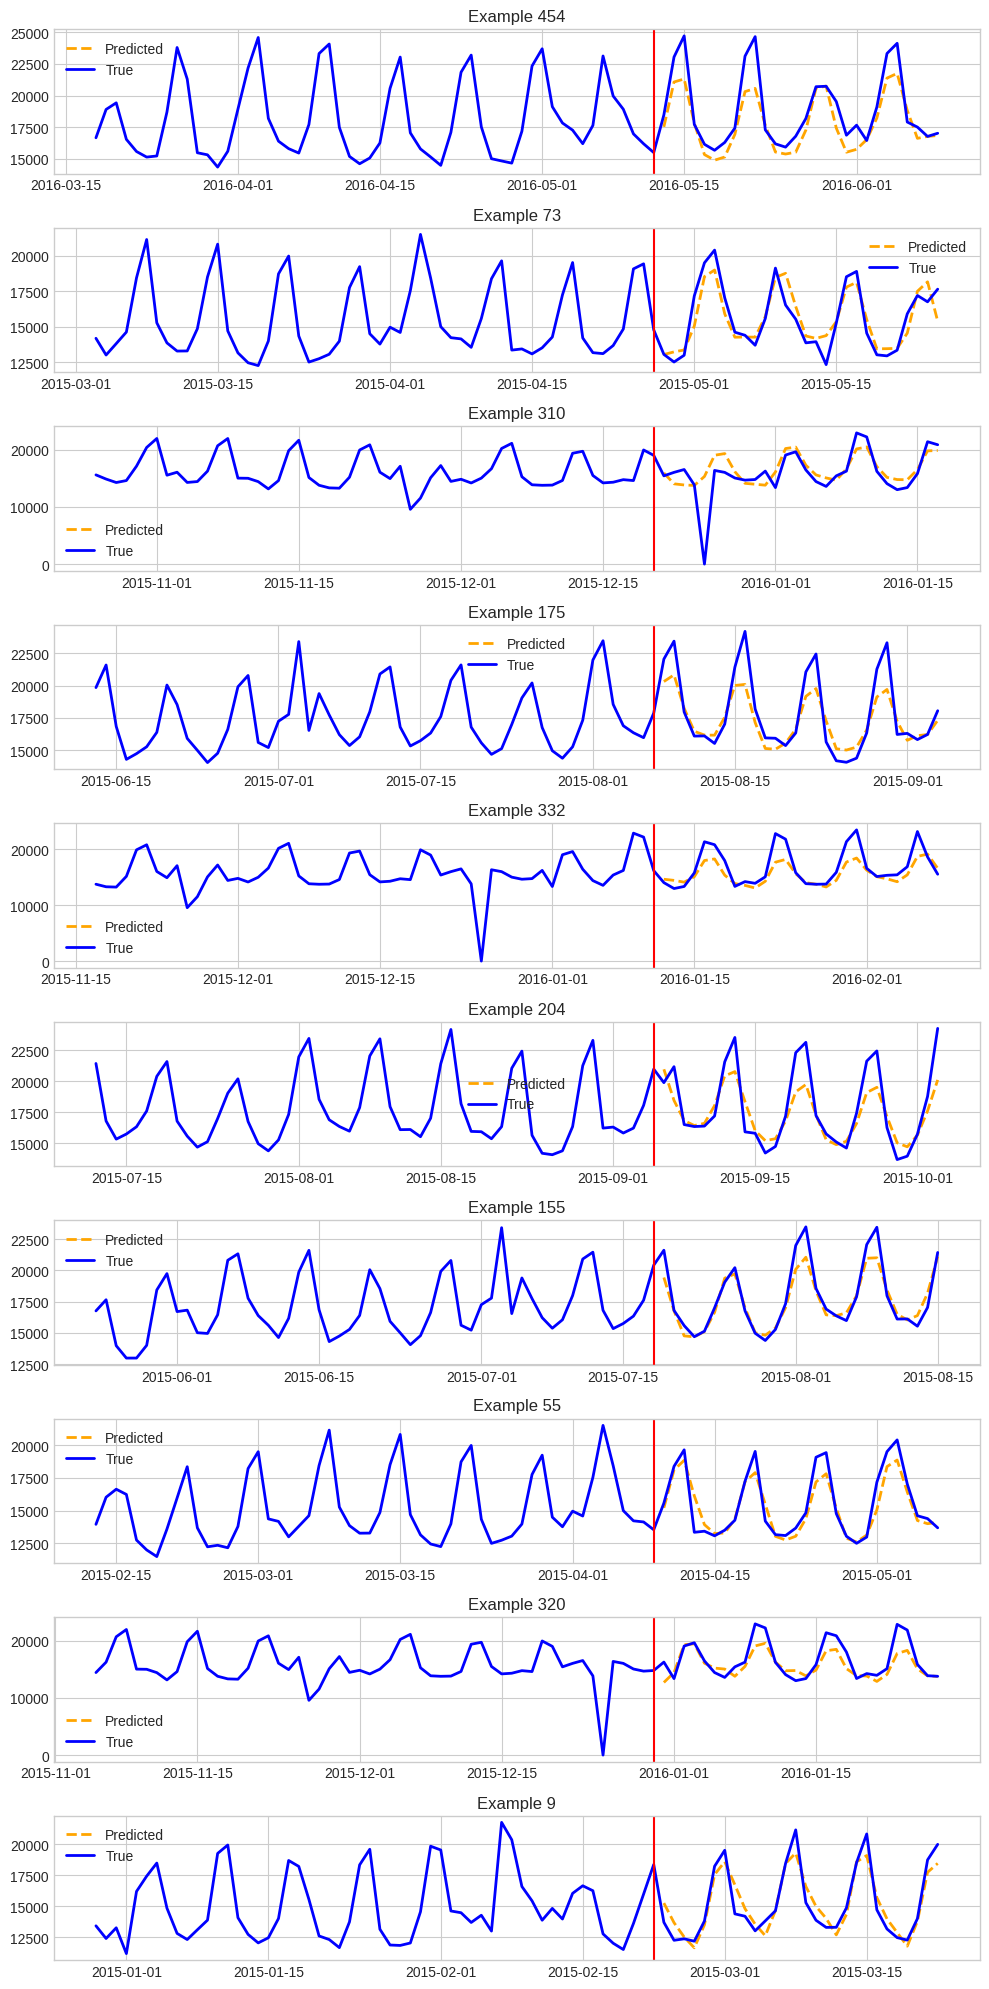

In [19]:
plot_predictions(
    input_df=test_data[test_data.state_id == "CA"],
    predictions_df=finetune_forecast[finetune_forecast.state_id == "CA"],
    freq="d",
    timestamp_column=column_specifiers["timestamp_column"],
    channel=column_specifiers["target_columns"][0],
)